In [39]:
import pandas as pd
import numpy as np
import os.path as op
import seaborn as sns
from nilearn import surface
import pingouin
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'

bids_folder = '/data/ds-numrisk/'

### Get Mutual information

In [40]:
mis = []


for subject in range(1, 65):
    for mask in ['NPC1_L', 'NPC1_R', 'NPC_L', 'NPC_R', 'NPC', 'NPC1']:
        for type in ['runwise', 'trialwise']:
            try:
                d = np.loadtxt(op.join(bids_folder, 'derivatives', f'mutualinfo_{type}_smoothed',
                                         f'sub-{subject}', 'func', f'sub-{subject}_mask-{mask}_logmutualinfo.txt'))

                d = pd.DataFrame({'mutual information': [d]},
                     index=pd.MultiIndex.from_product(((type, ), (subject,), (mask,)), names=['type', 'subject', 'mask']))
                mis.append(d)

            except Exception as e:
                pass
    #             
                print(f"Problem with subject {subject}:{e}")


mi = pd.concat(mis)

mi['mutual information'] = mi['mutual information'].astype(np.float)

Problem with subject 1:/data/ds-numrisk/derivatives/mutualinfo_runwise_smoothed/sub-1/func/sub-1_mask-NPC1_L_logmutualinfo.txt not found.
Problem with subject 1:/data/ds-numrisk/derivatives/mutualinfo_trialwise_smoothed/sub-1/func/sub-1_mask-NPC1_L_logmutualinfo.txt not found.
Problem with subject 1:/data/ds-numrisk/derivatives/mutualinfo_runwise_smoothed/sub-1/func/sub-1_mask-NPC1_R_logmutualinfo.txt not found.
Problem with subject 1:/data/ds-numrisk/derivatives/mutualinfo_trialwise_smoothed/sub-1/func/sub-1_mask-NPC1_R_logmutualinfo.txt not found.
Problem with subject 1:/data/ds-numrisk/derivatives/mutualinfo_runwise_smoothed/sub-1/func/sub-1_mask-NPC_L_logmutualinfo.txt not found.
Problem with subject 1:/data/ds-numrisk/derivatives/mutualinfo_trialwise_smoothed/sub-1/func/sub-1_mask-NPC_L_logmutualinfo.txt not found.
Problem with subject 1:/data/ds-numrisk/derivatives/mutualinfo_runwise_smoothed/sub-1/func/sub-1_mask-NPC_R_logmutualinfo.txt not found.
Problem with subject 1:/data/ds

ValueError: No objects to concatenate

## Get PDFs

In [41]:
df = []


for type in ['trialwise']:
    for subject in range(1, 65):
        for mask in ['NPC1_L', 'NPC1_R', 'NPC_L', 'NPC_R', 'NPC', 'NPC1']:
            for run in range(1, 7):
                try:
                    d = pd.read_csv(op.join(bids_folder, 'derivatives', f'decoding3_{type}_smoothed',
                                             f'sub-{subject}', 'func', f'sub-{subject}_run-{run}_mask-{mask}_pdf.tsv'), sep='\t', 
                                             header=[0], index_col=[0,1])

                    d.columns = d.columns.astype(np.float32)
                    d['type'], d['subject'], d['mask'], d['run'] = type, subject, mask, run
                    df.append(d.set_index(['type', 'subject', 'mask', 'run'], append=True))

                except Exception as e:
                    print(f"Problem with subject {subject}:{e}")

    
df = pd.concat(df)

df.shape

In [ ]:
df.columns = np.exp(df.columns.astype(np.float32))
df.columns = np.round((df.columns * 2)) / 2.


### Calculate itemwise pars

In [ ]:
pars = (df.columns[np.newaxis,:] * df).sum(1).to_frame('E')
pars['map'] = df.idxmax(1)
pars['sd'] = (np.abs(pars['E'].values[:, np.newaxis] - df.columns.astype(np.float32)[np.newaxis, :]) * df).sum(1).to_frame('sd')

pars = pars.reset_index(['stimulus', 'log(stimulus)'])
pars['log_error'] =  np.log(pars['E']) - pars['log(stimulus)']
pars['abs(log_error)'] = pars['log_error'].abs()

pars['error'] =  pars['E'] - pars['stimulus']
pars['abs(error)'] = pars['error'].abs()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_43121/3606045768.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pars = (df.columns[np.newaxis,:] * df).sum(1).to_frame('E')
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_43121/3606045768.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pars['sd'] = (np.abs(pars['E'].values[:, np.newaxis] - df.columns.astype(np.float32)[np.newaxis, :]) * df).sum(1).to_frame('sd')


In [ ]:
pars['entropy'] = -(np.log(df)*df).sum(1).values

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [ ]:
stimuli = [5, 7, 10, 14, 20, 28]

pars['E2'] = (np.array(stimuli)[np.newaxis, :] * df[stimuli] / df[stimuli].sum(1).values[:, np.newaxis]).sum(1).values


pars['sd2'] = ((np.abs(pars['E2'].values[:, np.newaxis] - np.array(stimuli)[np.newaxis, :])  * df[stimuli]).sum(1) / df[stimuli].sum(1)).values

In [ ]:
pars['map2'] = df[stimuli].idxmax(1).values

In [ ]:
%matplotlib inline

In [ ]:
pars

stimulus  log(stimulus)          E   map  \
type      subject mask   run                                             
trialwise 1       NPC1_L 1           5       1.609438  17.276053  15.0   
                         1           5       1.609438   7.039475   7.0   
                         1           5       1.609438   6.445702   6.5   
                         1           5       1.609438  61.612283  21.5   
                         1           5       1.609438  84.051800  61.0   
...                                ...            ...        ...   ...   
          64      NPC1   6          28       3.332205  64.486054  11.5   
                         6          28       3.332205  79.844945   5.0   
                         6          28       3.332205  51.564350   7.0   
                         6          28       3.332205  59.970730   7.0   
                         6          28       3.332205  72.397663  29.0   

                                     sd  log_error  abs(log_error)      error  \
type      subject mask   run                                                    
trialwise 1       NPC1_L 1     3.680207   1.239883        1.239883  12.276053   
                         1     0.684137   0.342096        0.342096   2.039475   
                         1     0.411591   0.253976        0.253976   1.445702   
                         1    34.363306   2.511423        2.511423  56.612283   
                         1    26.949222   2.821995        2.821995  79.051800   
...                                 ...        ...             ...        ...   
          64      NPC1   6    32.077358   0.834244        0.834244  36.486054   
                         6    33.128548   1.047882        1.047882  51.844945   
                         6    40.844221   0.610626        0.610626  23.564350   
                         6    35.471294   0.761652        0.761652  31.970730   
                         6    32.021628   0.949970        0.949970  44.397663   

                              abs(error)   entropy         E2       sd2  map2  
type      subject mask   run                                                   
trialwise 1       NPC1_L 1     12.276053  3.127700  15.039451  1.744286  14.0  
                         1      2.039475  1.673907   6.995991  0.020527   7.0  
                         1      1.445702  1.478437   6.969198  0.062924   7.0  
                         1     56.612283  5.473846  19.607361  4.976763  20.0  
                         1     79.051800  5.439225  27.469627  0.997224  28.0  
...                                  ...       ...        ...       ...   ...  
          64      NPC1   6     36.486054  5.551979  15.367089  4.875613  14.0  
                         6     51.844945  5.556272  11.631956  7.080836   5.0  
                         6     23.564350  4.963551   7.915575  1.738317   7.0  
                         6     31.970730  5.417033  11.742139  6.814896   7.0  
                         6     44.397663  5.585594  17.489785  7.301210  28.0  

[82944 rows x 13 columns]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
sns.set_context('poster')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/decoding/confusion_matrix.pdf'

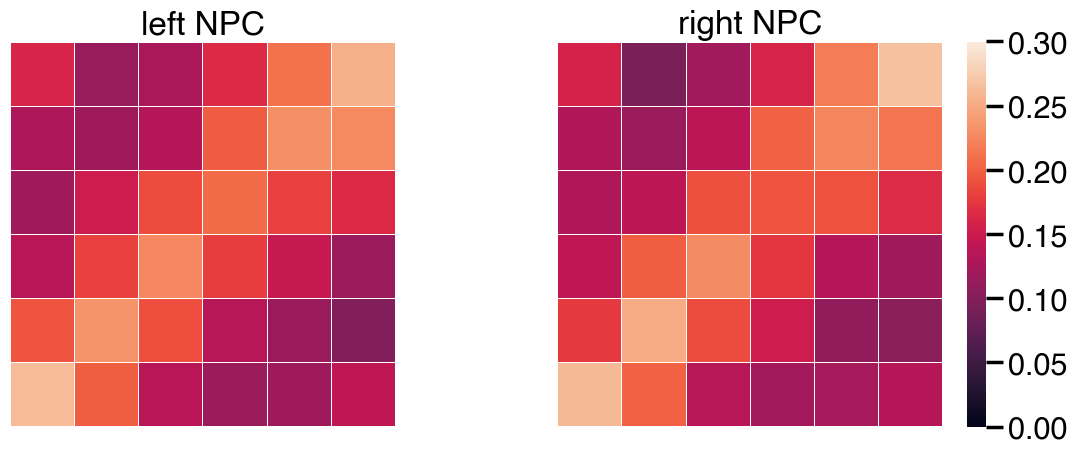

In [ ]:
plt.subplot(121)
tmp = pars.loc['trialwise'].xs('NPC_L', 0, 'mask').groupby(['stimulus', 'map2']).count().unstack('map2')['map']

tmp = tmp / tmp.sum(0)
tmp = tmp.iloc[::-1, :]

ax = sns.heatmap(tmp, vmin=0.0, vmax=.3, square=True, linewidths=.5, linecolor='white', cbar=False)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xticks([])
ax.set_yticks([])
plt.title('left NPC')

plt.subplot(122)
tmp = pars.loc['trialwise'].xs('NPC_R', 0, 'mask').groupby(['stimulus', 'map2']).count().unstack('map2')['map']

tmp = tmp / tmp.sum(0)
tmp = tmp.iloc[::-1, :]

ax = sns.heatmap(tmp, vmin=0.0, vmax=.3, square=True, linewidths=.5, linecolor='white', )
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xticks([])
ax.set_yticks([])
plt.title('right NPC')

plt.gcf().set_size_inches(14, 5)

# plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/decoding/confusion_matrix.pdf', transparent=True)

In [ ]:
ix_ = pd.IndexSlice



## Calculate subjectwise pars

In [ ]:
import matplotlib.pyplot as plt

In [15]:
r = pars.groupby(['type', 'subject', 'mask']).apply(lambda d: pingouin.corr(d['E'], d['stimulus']))
r['r_map'] = pars.groupby(['type', 'subject', 'mask']).apply(lambda d: pingouin.corr(d['map'], d['stimulus']))['r']
r['r_2'] = pars.groupby(['type', 'subject', 'mask']).apply(lambda d: pingouin.corr(d['E2'], d['stimulus']))['r']
r['r_map2'] = pars.groupby(['type', 'subject', 'mask']).apply(lambda d: pingouin.corr(d['map2'], d['stimulus']))['r']
r['accuracy'] = pars.groupby(['type', 'subject', 'mask']).apply(lambda d: (d['map2'] == d['stimulus']).mean())

r = r.droplevel(-1).join(mi)


sns.distplot(r['r'])
sns.distplot(r['r_map'])
sns.distplot(r['r_2'])
sns.distplot(r['r_map2'])
sns.lmplot('r', 'r_map', data=r)
sns.lmplot('r_map', 'r_map2', data=r)
plt.plot([0.0, 0.5], [0.0, 0.5], c='k')


sns.lmplot('r', 'r_map2', data=r)
plt.plot([0.0, 0.5], [0.0, 0.5], c='k')


sns.lmplot('r_2', 'mutual information', data=r.reset_index(), hue='mask', col='type')

NameError: name 'mi' is not defined

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


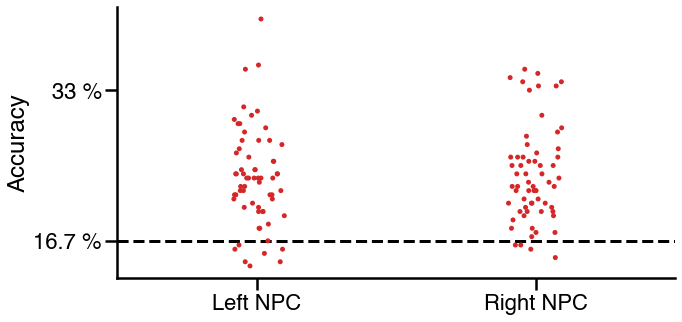

In [ ]:
# sns.set_style('white')
tmp = r.loc[ix_['trialwise', :, ['NPC_L', 'NPC_R']]]

fac = sns.catplot('mask', 'accuracy', data=tmp.reset_index(), color=sns.color_palette()[3], dodge=False,
                 aspect=2.)
plt.axhline(1./6., c='k', ls='--')
# plt.ylim(0, None)
# plt.yticks([1./6., 1/3., 1/2.], ['16.7%', '33 %', '50 %'])
plt.yticks([1./6., 1/3., 1/2.][:2], ['16.7 %', '33 %', '50%'][:2])

fac.set(xlabel=None)
fac.set(ylabel='Accuracy')


ax = fac.axes.ravel()[0]

ax.set_xticklabels(['Left NPC', 'Right NPC'])

plt.tight_layout()

plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/decoding/accuracy.pdf', transparent=True)

In [ ]:
r

n         r          CI95%         p-val  \
type      subject mask                                                 
trialwise 1       NPC     216  0.433089   [0.32, 0.54]  2.745748e-11   
                  NPC1    216  0.310333   [0.18, 0.43]  3.322784e-06   
                  NPC1_L  216  0.264815   [0.14, 0.38]  8.149536e-05   
                  NPC1_R  216  0.335021   [0.21, 0.45]  4.614898e-07   
                  NPC_L   216  0.385166   [0.27, 0.49]  4.758614e-09   
...                       ...       ...            ...           ...   
          64      NPC1    216  0.083932  [-0.05, 0.22]  2.192383e-01   
                  NPC1_L  216  0.112741  [-0.02, 0.24]  9.841061e-02   
                  NPC1_R  216  0.025559  [-0.11, 0.16]  7.087574e-01   
                  NPC_L   216 -0.031400   [-0.16, 0.1]  6.462876e-01   
                  NPC_R   216  0.175565    [0.04, 0.3]  9.726540e-03   

                               BF10     power     r_map       r_2    r_map2  \
type      subject mask                                                        
trialwise 1       NPC     3.122e+08  0.999999  0.373954  0.483719  0.419197   
                  NPC1     3916.888  0.996867  0.348381  0.385697  0.330098   
                  NPC1_L    189.696  0.977656  0.239920  0.324886  0.310956   
                  NPC1_R  2.582e+04  0.999145  0.357133  0.340903  0.316507   
                  NPC_L   2.109e+06  0.999965  0.346367  0.488505  0.434699   
...                             ...       ...       ...       ...       ...   
          64      NPC1         0.18  0.233430 -0.069068  0.094258  0.026307   
                  NPC1_L      0.331  0.380582  0.085844  0.160318  0.061306   
                  NPC1_R      0.091  0.066082  0.125112  0.122714  0.133386   
                  NPC_L       0.095  0.074422  0.118226  0.256546  0.166989   
                  NPC_R       2.354  0.737114  0.078581  0.113716  0.093820   

                          accuracy  mutual information  
type      subject mask                                  
trialwise 1       NPC     0.291667        -2330.825072  
                  NPC1    0.245370        -1716.031134  
                  NPC1_L  0.245370        -1546.207398  
                  NPC1_R  0.240741        -1332.949487  
                  NPC_L   0.287037        -2313.754686  
...                            ...                 ...  
          64      NPC1    0.231481        -1967.639662  
                  NPC1_L  0.212963        -1796.004871  
                  NPC1_R  0.199074        -1714.271069  
                  NPC_L   0.217593        -2645.174317  
                  NPC_R   0.226852        -1835.673617  

[384 rows x 11 columns]

In [ ]:
(r.xs('NPC_L', 0, 'mask')['accuracy'] > 1./6.).sum(), (r.xs('NPC_R', 0, 'mask')['accuracy'] > 1./6.).sum()

(56, 60)

In [16]:
r.groupby(['mask'])['r'].describe()

,count,mean,std,min,25%,50%,75%,max
mask,,,,,,,,
NPC,64.0,0.193385,0.136249,-0.072013,0.085492,0.196629,0.290448,0.556298
NPC1,64.0,0.156186,0.128957,-0.083550,0.065968,0.136945,0.253890,0.500556
NPC1_L,64.0,0.133233,0.114579,-0.083391,0.051561,0.113817,0.195364,0.456807
NPC1_R,64.0,0.165778,0.122687,-0.065442,0.073201,0.153183,0.264258,0.474287
NPC_L,64.0,0.116850,0.131536,-0.110280,0.014595,0.096452,0.170398,0.425604
NPC_R,64.0,0.215559,0.105528,0.024508,0.138462,0.218230,0.275351,0.552843


In [17]:
tmp = r.unstack('mask')

pingouin.ttest(tmp['r', 'NPC_L'], tmp['r', 'NPC_R'], True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.168325,63,two-sided,5.479789e-08,"[-0.13, -0.07]",0.827802,2.411e+05,1.0


In [18]:
r.groupby(['mask'])['accuracy'].describe()

,count,mean,std,min,25%,50%,75%,max
mask,,,,,,,,
NPC,64.0,0.245949,0.055522,0.157407,0.208333,0.240741,0.278935,0.393519
NPC1,64.0,0.232060,0.048929,0.101852,0.194444,0.236111,0.259259,0.333333
NPC1_L,64.0,0.224682,0.050580,0.106481,0.194444,0.226852,0.254630,0.351852
NPC1_R,64.0,0.221933,0.048988,0.120370,0.185185,0.217593,0.259259,0.342593
NPC_L,64.0,0.236256,0.053693,0.138889,0.203704,0.236111,0.265046,0.412037
NPC_R,64.0,0.238498,0.052476,0.148148,0.202546,0.226852,0.259259,0.356481


In [20]:
r.groupby(['mask']).apply(lambda d: pingouin.ttest(d['accuracy'], 1/6.))

,,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
mask,,,,,,,,,
NPC,T-test,11.423594,63,two-sided,5.392559e-17,"[0.23, 0.26]",1.427949,1.116e+14,1.0
NPC1,T-test,10.691901,63,two-sided,8.627127e-16,"[0.22, 0.24]",1.336488,7.579e+12,1.0
NPC1_L,T-test,9.175876,63,two-sided,3.216757e-13,"[0.21, 0.24]",1.146985,2.468e+10,1.0
NPC1_R,T-test,9.025341,63,two-sided,5.853392e-13,"[0.21, 0.23]",1.128168,1.386e+10,1.0
NPC_L,T-test,10.368424,63,two-sided,2.995292e-15,"[0.22, 0.25]",1.296053,2.269e+12,1.0
NPC_R,T-test,10.950863,63,two-sided,3.211300e-16,"[0.23, 0.25]",1.368858,1.976e+13,1.0


In [23]:
# %matplotlib inline
# sns.set_context('talk')
# fac = sns.catplot('mask', 'accuracy', data=r.reset_index(), col='type', aspect=1.25)


# for ax in fac.axes.ravel():
#     ax.axhline(1/6., c='k', ls='--')

    
# fac = sns.FacetGrid(r.reset_index(), col='type', size=6)

# fac.map(sns.stripplot, 'mask', 'accuracy', 'mask', palette=sns.color_palette())
# fac.map(lambda *args, **kwargs: plt.axhline(1/6., c='k', ls='--'))

# fac.map(sns.boxplot, 'mask', 'accuracy', 
#         meanprops={'color': 'k', 'ls': '-', 'lw': 2},
#         showmeans=True, meanline=True, showfliers=False, showbox=False, showcaps=False, 
#         medianprops={'visible':False},
#         whiskerprops={'visible': False},)

# # sns.boxplot(showmeans=True,
# #             meanline=True,
# #             meanprops={'color': 'k', 'ls': '-', 'lw': 2},
# #             medianprops={'visible': False},
# #             whiskerprops={'visible': False},
# #             zorder=10,
# #             x="mask",
# #             y="accuracy",
# #             data=r.reset_index(),
# #             showfliers=False,
# #             showbox=False,
# #             showcaps=False,
# #             ax=fac)

## Get slopes

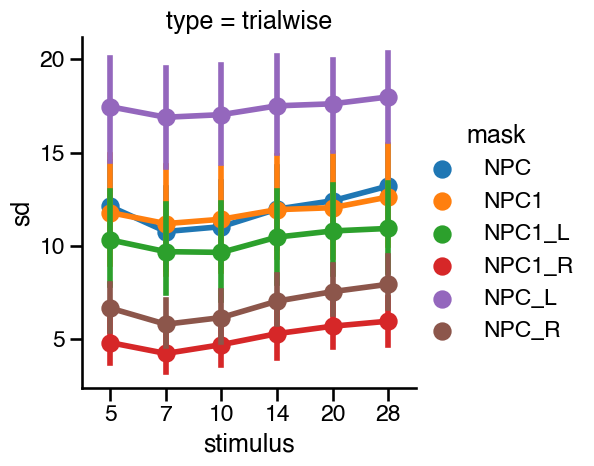

In [25]:
sns.catplot(x='stimulus', y='sd', hue='mask', col='type', data=pars.groupby(['type', 'subject', 'mask', 'stimulus']).mean().reset_index(), kind='point')

In [26]:
tmp = pars.query('mask in ["NPC1_L", "NPC_L", "NPC_R"]').loc['trialwise'].groupby(['subject', 'mask', 'stimulus']).mean().reset_index()

In [27]:
pingouin.rm_corr(tmp[tmp['mask'] == 'NPC1_L'], 'stimulus', 'sd', subject='subject')

,r,dof,pval,CI95%,power
rm_corr,0.294799,319,7.398592e-08,"[0.19, 0.39]",0.999735


In [28]:
pingouin.rm_corr(tmp[tmp['mask'] == 'NPC_L'], 'stimulus', 'sd', subject='subject')

,r,dof,pval,CI95%,power
rm_corr,0.234381,319,0.000022,"[0.13, 0.34]",0.989414


In [29]:
pingouin.rm_corr(tmp[tmp['mask'] == 'NPC_R'], 'stimulus', 'sd', subject='subject')

,r,dof,pval,CI95%,power
rm_corr,0.429904,319,7.173198e-16,"[0.34, 0.52]",1.0


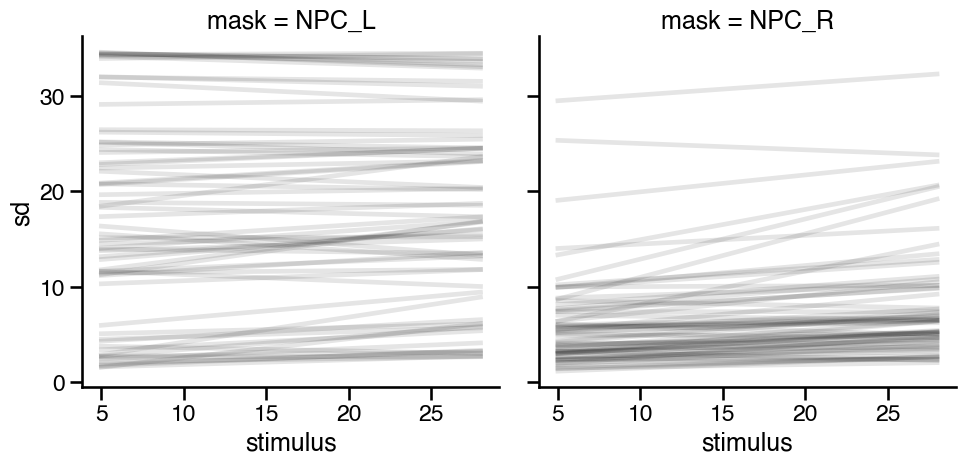

In [31]:
sns.lmplot(x='stimulus', y='sd', hue='subject', col='mask',
           data=pars.query('mask in ["NPC_L", "NPC_R"]').loc['trialwise'].groupby(['subject', 'mask', 'stimulus']).mean().reset_index(), 
          scatter=False, ci=None, legend=False, palette=['k'], line_kws={'alpha':.1})

In [32]:
sns.set_context('talk')


In [33]:
from sklearn import linear_model

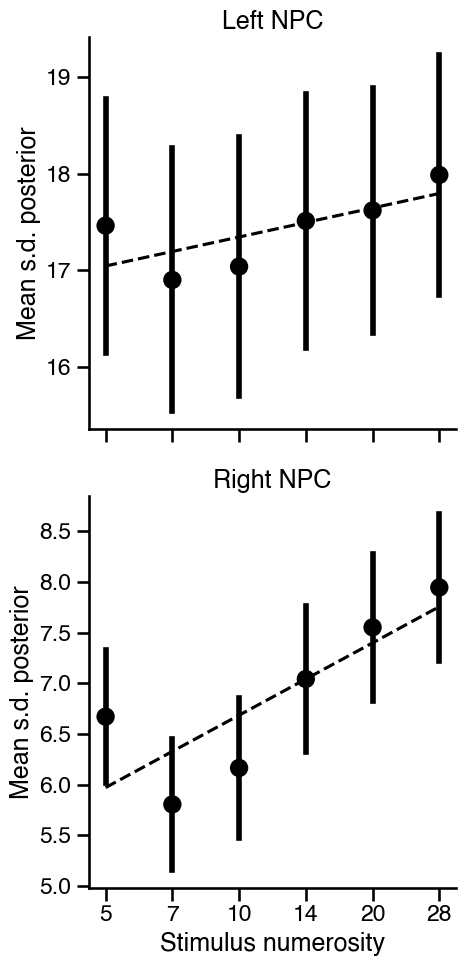

In [38]:
tmp = pars.query('mask in ["NPC_L", "NPC_R"]').loc['trialwise'].groupby(['subject', 'mask', 'stimulus']).mean().reset_index()

fac = sns.catplot(x='stimulus', y='sd', row='mask',
           data=tmp, 
#                   col_wrap=1,
           kind='point', sharey=False,
                  palette=['k'],
                  errorbar='se')
#                  line_kws={'lw':1., 'c':'k'})

fac.set(ylabel='Mean s.d. posterior')
fac.set(xlabel='Stimulus numerosity')

tmp = pars.query('mask in ["NPC_L", "NPC_R"]').loc['trialwise'].groupby(['subject', 'mask', 'stimulus']).mean().reset_index()

model = linear_model.LinearRegression()
tmp = tmp.groupby(['mask', 'stimulus']).mean()['sd']
model.fit(np.arange(6)[:, np.newaxis], tmp.loc['NPC_L'].values[:, np.newaxis])
fac.axes[0][0].plot(model.predict(np.arange(6)[:, np.newaxis]), c='k', ls='--')
fac.axes[0][0].set_title('Left NPC')

model.fit(np.arange(6)[:, np.newaxis], tmp.loc['NPC_R'].values[:, np.newaxis])
fac.axes[1][0].plot(model.predict(np.arange(6)[:, np.newaxis]), c='k', ls='--')
fac.axes[1][0].set_title('Right NPC')
plt.tight_layout()

# plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/brainbehavior/dm.pdf', transparent=False)

In [33]:
from sklearn import linear_model

In [32]:
pars.groupby('mask').mean()

,stimulus,log(stimulus),E,map,sd,log_error,abs(log_error),error,abs(error),entropy,E2,sd2,map2
mask,,,,,,,,,,,,,
NPC,14.0,2.470821,28.185657,14.338252,11.924720,0.609249,0.817626,14.185657,17.343929,3.732385,13.607601,3.838266,13.476635
NPC1,14.0,2.470821,28.801436,13.897606,11.842167,0.557819,0.869835,14.801436,19.131501,3.175365,13.362309,2.828846,13.150608
NPC1_L,14.0,2.470821,27.383263,14.679977,10.317338,0.489622,0.857785,13.383263,18.325875,2.955761,13.645343,2.479076,13.518808
NPC1_R,14.0,2.470821,19.129707,14.053385,5.124071,0.203133,0.676511,5.129707,11.459334,2.346675,13.473874,1.858792,13.411892
NPC_L,14.0,2.470821,36.464723,13.887008,17.421461,0.852387,1.028194,22.464723,25.056935,4.014775,13.439420,3.900310,13.133174
NPC_R,14.0,2.470821,20.479620,14.126447,6.864564,0.334161,0.652235,6.479620,11.147174,2.954770,13.504673,2.885193,13.472584


/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


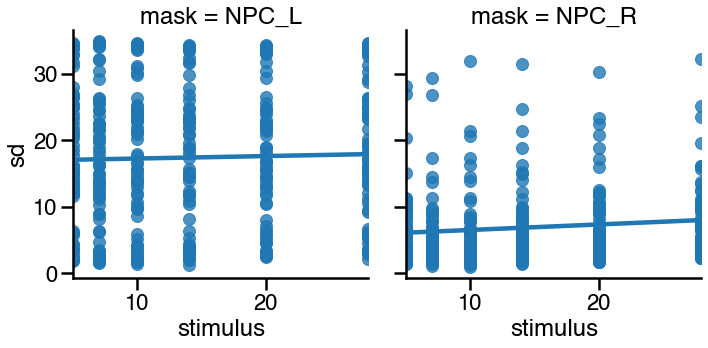

In [33]:
sns.lmplot('stimulus', 'sd', col='mask',
           data=pars.query('mask in ["NPC_L", "NPC_R"]').loc['trialwise'].groupby(['subject', 'mask', 'stimulus']).mean().reset_index(), 
          scatter=True, ci=None, legend=False, palette=['k'])

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplo

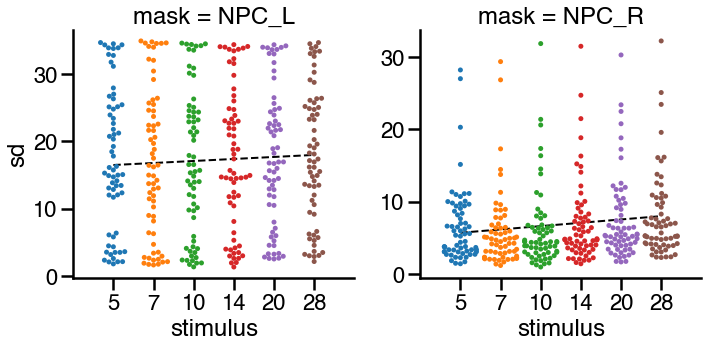

In [34]:
fac = sns.catplot('stimulus', 'sd', col='mask',  sharey=False,
            ci=False,
            data=pars.query('mask in ["NPC_L", "NPC_R"]').loc['trialwise'].groupby(['subject', 'mask', 'stimulus']).mean().reset_index(), kind='swarm')


fac.axes.ravel()[0].plot([0, 5],[16.5, 18], c='k', ls='--', lw=2)
fac.axes.ravel()[1].plot([0, 5],[5.7, 8], c='k', ls='--', lw=2)
fac.set(xlim=(-1, 6))

In [35]:
precision = (1./pars.groupby(['type', 'subject', 'mask', 'stimulus'])['sd'].apply(lambda d: np.clip(d, .5, 50).mean())).to_frame('neural precision')

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


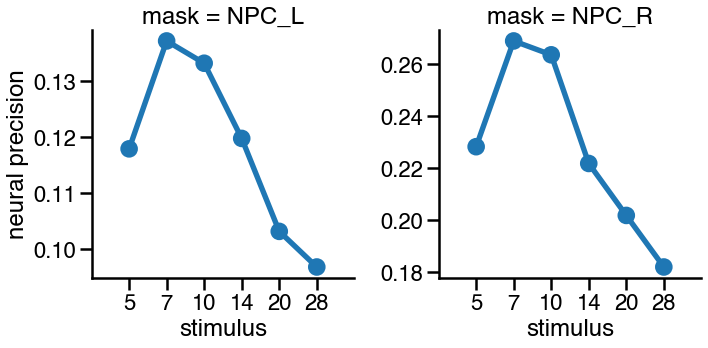

In [36]:
fac = sns.catplot('stimulus', 'neural precision', col='mask',  sharey=False,
            ci=False,
            data=precision.query('mask in ["NPC_L", "NPC_R"]').loc['trialwise'].groupby(['subject', 'mask', 'stimulus']).mean().reset_index(), kind='point')


# fac.axes.ravel()[0].plot([0, 5],[16.5, 18], c='k', ls='--', lw=2)
# fac.axes.ravel()[1].plot([0, 5],[5.7, 8], c='k', ls='--', lw=2)
fac.set(xlim=(-1, 6))

In [37]:
tmp = pars.groupby(['type', 'subject', 'mask', 'stimulus']).mean()
intercepts = tmp.groupby(['type', 'subject', 'mask']).apply(lambda d:pingouin.linear_regression(d.reset_index()['stimulus'] - d.reset_index()['stimulus'].mean(), d['sd']).loc[0, 'coef'])
slopes = tmp.groupby(['type', 'subject', 'mask']).apply(lambda d:pingouin.linear_regression(d.reset_index()['stimulus']  - d.reset_index()['stimulus'].mean(), d['sd']).loc[1, 'coef'])

In [ ]:
tmp = pars.groupby(['type', 'subject', 'mask', 'stimulus']).mean()
intercepts2 = tmp.groupby(['type', 'subject', 'mask']).apply(lambda d:pingouin.linear_regression(d.reset_index()['stimulus'], d['sd2']).loc[0, 'coef'])
slopes2 = tmp.groupby(['type', 'subject', 'mask']).apply(lambda d:pingouin.linear_regression(d.reset_index()['stimulus'], d['sd2']).loc[1, 'coef'])

In [ ]:
tmp = pars.groupby(['type', 'subject', 'mask', 'stimulus']).mean()
precision_intercepts = precision.groupby(['type', 'subject', 'mask']).apply(lambda d:pingouin.linear_regression(d.reset_index()['stimulus'] - d.reset_index()['stimulus'].mean(), np.log(d['neural precision'])).loc[0, 'coef'])
precision_slopes = precision.groupby(['type', 'subject', 'mask']).apply(lambda d:pingouin.linear_regression(d.reset_index()['stimulus']  - d.reset_index()['stimulus'].mean(), d['neural precision']).loc[1, 'coef'])

In [ ]:
sns.swarmplot('mask', 'slope', 'type', data=slopes.to_frame('slope').reset_index())
plt.axhline(0, c='k', ls='--')

In [ ]:
sns.swarmplot('mask', 'slope', 'type', data=precision_slopes.to_frame('slope').reset_index())
plt.axhline(0, c='k', ls='--')

In [ ]:

sns.distplot(slopes.to_frame('slope'))

In [ ]:

sns.distplot(precision_slopes.to_frame('slope'))

###  Combine everything

In [ ]:
precision

In [ ]:
results = pars.groupby(['type', 'subject', 'mask'])[['neural precision', 'sd', 'sd2', 'error', 'abs(error)']].mean().join(r[['r', 'r_map', 'r_map2', 'r_2', 'accuracy', 'mutual information']])
results['neural precision'] = 1./pars.groupby(['type', 'subject', 'mask'])['sd'].mean().to_frame('neural precision')
results = results.join(precision_slopes.to_frame('precision_slope'))
results = results.join(slopes.to_frame('slope'))
results = results.join(intercepts.to_frame('intercept'))
results = results.join(slopes2.to_frame('slope2'))
results = results.join(intercepts2.to_frame('intercept2'))


# results.to_csv(op.join(bids_folder, 'derivatives', 'summary_data', 'neural_results_aug2021.tsv'), sep='\t')

In [ ]:
sns.distplot(results['neural precision'])

In [ ]:
sns.distplot(np.log(results['neural precision']))

In [ ]:
(1./pars.groupby(['type', 'subject', 'mask'])['sd'].apply(lambda d: np.clip(d, .5, 50).mean())).to_frame('neural precision')

In [ ]:
results['neural precision']

In [ ]:
results.groupby(['type', 'mask']).apply(lambda d: pingouin.corr(d['neural precision'], d['slope']))

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


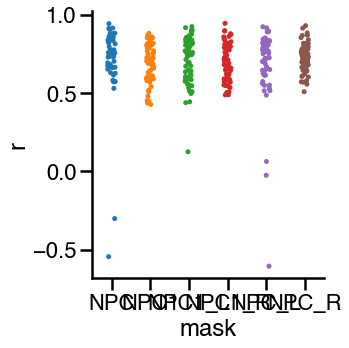

In [29]:

tmp = pars.groupby(['subject', 'mask']).apply(lambda d: pingouin.corr(d['sd'], d['entropy']))


sns.catplot('mask', 'r', data=tmp.reset_index())